In [ ]:
# prerequisites
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model,Sequential
from keras import backend as K
from keras import objectives
from scipy.stats import norm

We loaded the training and test data from MNIST, converted their type to float, and normalized them. Then, we changed the shape of the data. The shape of the data is the number of samples by 28x28, and we reshape it to the number of samples by the rest. The remaining data is reshaped to -1. So "X_train shape[0]" represents the number of samples we have, and -1 represents the rest, which becomes 28 multiplied by 28. We do this for both the test and train data.

We defined "batch size" and "epochs" as 100. Then, we specified the "hidden and z" layers, which are the middle layers we want to reach. We also defined the number of hidden units for the dense layers that we will use later, which will be specified in the following cells.


In [ ]:

# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
print(x_tr.shape)
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape)
print(x_tr.shape, x_te.shape)
print(y_tr.shape)

# network parameters
batch_size, n_epoch = 100, 100
n_hidden, z_dim = 256, 2

11493376/11490434 [==============================] - 2s 0us/step
(60000, 28, 28)
(60000, 784)
(60000, 784) (10000, 784)
(60000,)


In this section, we defined the encoder. 
First, it takes the images as input. 
We applied a dense layer to the input, which is the first "hidden" layer with a size of 256, and we used the ReLU activation function. The second dense layer is half the size of the "hidden" layer, which means its size is 128. This layer branches into two: one for the mean and one for the log variance. 

So, the layers of the encoder network are as follows: 
- Takes an input image 
- Then two dense layers: 256 and 128 with ReLU activation 
- After the 128 layer, it branches into two vectors: one for the mean and one for the log variance.


In [ ]:
# encoder
x = Input(shape=(x_tr.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

mu = Dense(z_dim)(x_encoded)
log_var = Dense(z_dim)(x_encoded)

In [ ]:
print(x_encoded)

Tensor("dense_2/Relu:0", shape=(None, 128), dtype=float32)


This layer is a function. 
This function generates a sample from the log variance and mean. 
It takes the log variance and mean as inputs and generates an epsilon, which is a random normal value in the shape of 2, previously defined. This means in the same shape as the mean and variance, but with the batch size. 

When we run the network, we have a mean and variance for each batch size. The generated distribution is normal, meaning it is generated with a mean of 0 and a variance of 1. To convert the normal distribution to the desired standard distribution, we multiply the variance by the generated epsilon and add the mean. But since we are learning the log variance (because we have the log variance), we exponentiate the log variance. 

If we want to place a function layer in Keras networks, we need to use the Lambda layer, where the first argument is the function we want to use, and the second argument is the output shape and input shape of the function.


In [ ]:
# sampling function
def sampling(args):
    mu, log_var = args
    print(mu,log_var)
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

Tensor("dense_3/BiasAdd:0", shape=(None, 2), dtype=float32) Tensor("dense_4/BiasAdd:0", shape=(None, 2), dtype=float32)


Now we enter the decoder phase. 
In the decoder, the first layer is 128 units, followed by 256 units, and the final layer is a sigmoid layer with 784 units, which corresponds to the image size. These layers are built, and inputs are fed into them.


In [ ]:
# decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
print(z_decoded)
z_decoded = z_decoder2(z_decoded)
print(z_decoded)
y = y_decoder(z_decoded)

Tensor("dense_5/Relu:0", shape=(100, 128), dtype=float32)
Tensor("dense_6/Relu:0", shape=(100, 256), dtype=float32)


In this network, we don't have a specific target; therefore, we define the loss by combining two loss functions. The first loss is cross-entropy. This loss takes the following inputs:
1- The generated output 
2- The target, i.e., the output we want to produce. 

As the difference between these two inputs decreases, this loss decreases and eventually becomes zero. The second part of the loss is statistical, meaning each pixel of the images we provide has a statistical distribution. For example, these seven numbers have similar distributions. 

In the 2D plot we ultimately draw, this is shown—meaning that the distribution of the ones is similar, the twos are similar, and so on. In general, the generated image's distribution should resemble the distribution of the image we provided. One part is producing the exact same image we gave it, and the second part is having a similar distribution. Then we assign a coefficient to it and define a total loss.

In the model being built, we input the previously defined X and the generated Y. We also add the defined loss, and then we compile the model.


In [ ]:
# loss
reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

# build model
vae = Model(x, y)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            258         dense_2[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_7 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_7.
  'be expecting any data to be passed to {0}.'.format(name))


First, we shuffle the data, then we train the network using the `fit` function. We provide the number of epochs and batch size, and we define the validation data as the test data. Finally, we train the model using the `fit` function.


In [ ]:
# train
trained_vae=vae.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 62us/step - loss: 134.9685 - val_loss: 138.0267
Epoch 2/100
60000/60000 [==============================] - 4s 59us/step - loss: 134.7702 - val_loss: 137.5220
Epoch 3/100
60000/60000 [==============================] - 4s 59us/step - loss: 134.9797 - val_loss: 138.0788
Epoch 4/100
60000/60000 [==============================] - 4s 60us/step - loss: 135.3318 - val_loss: 138.2493
Epoch 5/100
60000/60000 [==============================] - 3s 57us/step - loss: 135.5882 - val_loss: 138.1268
Epoch 6/100
60000/60000 [==============================] - 3s 57us/step - loss: 135.3728 - val_loss: 138.9123
Epoch 7/100
60000/60000 [==============================] - 3s 57us/step - loss: 135.2217 - val_loss: 137.7619
Epoch 8/100
60000/60000 [==============================] - 3s 58us/step - loss: 135.0558 - val_loss: 139.2472
Epoch 9/100
60000/60000 [==============================] - 3s 58us/ste

We use the `history` method to plot the loss.


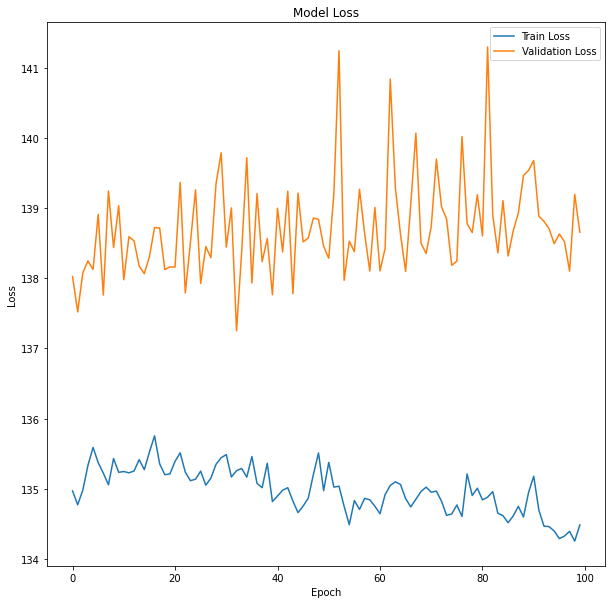

In [ ]:
# #Plot Accuracy
# fig_Accuracy = plt.figure(figsize=(10, 10))
# plt.plot(trained_vae.history['accuracy'])
# plt.plot(trained_vae.history['val_accuracy'])
# plt.title("Model accuracy")
# plt.ylabel("Accuracy")
# plt.xlabel("Epoch")
# plt.legend(["Train Accuracy","Validation Accuracy"])
# plt.show()


#Plot Loss
fig_Loss = plt.figure(figsize=(10, 10))
plt.plot(trained_vae.history['loss'])
plt.plot(trained_vae.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss","Validation Loss"])
plt.show()


In this section, we build an encoder. Previously, we created a series of layers. The variance part, since it represents dispersion, is not useful for our task. The mean represents a point on the plane. We pass the input from the X part to the mean and get the output.

The new network we define is the same as the previously trained network, but we remove the first dense layer, the second dense layer, and the dense layer connected to the mean layer. This package becomes the encoder. Then, we provide input to the encoder and plot it in 2D space.


In [ ]:
encoder = Model(x, mu)
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


In this section, we use the `predict` method, provide input, and get the output. In fact, we give input, and it returns the output of the trained network. The dimensions of the output represent a 2D image and return our data in 2D form.

We then plot the data, with the first component on the x-axis and the second component on the y-axis. The color is defined by 0, 1, 2, 3, meaning all data labeled as 0 will be assigned color 0. The color is assigned according to the target, and each class is given a specific color for visualization.


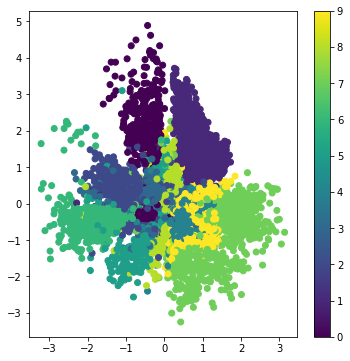

In [ ]:
# Plot of the digit classes in the latent space
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
plt.colorbar()
plt.show()

In this section, we separate the decoder. For the decoder, we define an input, which is the `z_dim` (which is 2). We use this as the input. Then, we use the 128 and 256 layers that were part of the decoder. These layers are used, and the previous inputs are provided to them. It then defines the layers for itself and defines the generator in this way, starting from the inputs of the decoder to the final output, which is the `Y`. Essentially, the decoder is taken and renamed as the generator, aiming to generate images.


In [ ]:
# build decoder
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


In this section, we first create a black image with dimensions of 28x10 and 28x10, which becomes 10 images in 10 images. Then, we assign a series of random numbers to the x and y axes, generating 10 numbers. These numbers are passed in a permuted way to the generator. A `z_sample` is produced in a permuted form, and then this `z_sample` is given to the generator for prediction, which is essentially the output of the decoder.

Since we want the output to be an image, we reshape it to 28x28 and then plot it. We do this by specifying that, in the image I created, for example, in column 0 to 28, draw the first image. In this way, we create an image.



[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
[-1.64485363 -1.03643339 -0.67448975 -0.38532047 -0.12566135  0.12566135
  0.38532047  0.67448975  1.03643339  1.64485363]


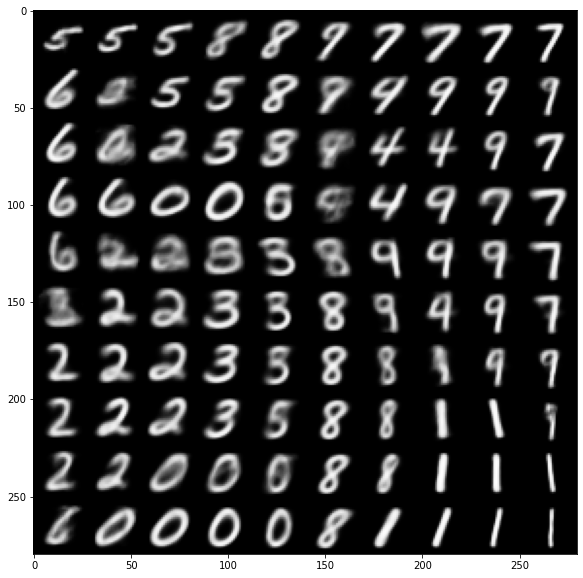

In [ ]:
# display a 2D manifold of the digits
n = 10 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# print(n)

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
print(np.linspace(0.05, 0.95, n))
print(grid_x)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
encoded_x_tr=encoder.predict(x_tr, batch_size=batch_size)

Now I want to build a classification network. I created a function that builds the model with the final dense layers, and I assign values arbitrarily. We use the encoder from above and add two dense layers. Here, we added two dense layers with sizes 20 and 20, and we take an output of size 10. I one-hot encoded the targets and used the data from the encoder to fit the model.

As a result, I pass all the training data through the encoder, which I had previously separated, and let it predict. That is, the trained data that passed through the encoder is now used to fit these two dense layers. In other words, I train it.


In [ ]:
def create_model():
    model=Sequential()
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(10,activation='softmax'))

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
cls=create_model()
from keras.utils import np_utils
train_targets=np_utils.to_categorical(y_tr)
classification=cls.fit(encoded_x_tr,train_targets, batch_size=100 , epochs=100 , validation_split=0.1)




Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 2s 46us/step - loss: 1.4138 - accuracy: 0.5127 - val_loss: 0.9022 - val_accuracy: 0.7558
Epoch 2/100
54000/54000 [==============================] - 2s 46us/step - loss: 0.8787 - accuracy: 0.7449 - val_loss: 0.7316 - val_accuracy: 0.8018
Epoch 3/100
54000/54000 [==============================] - 2s 44us/step - loss: 0.7771 - accuracy: 0.7703 - val_loss: 0.6585 - val_accuracy: 0.8087
Epoch 4/100
54000/54000 [==============================] - 2s 42us/step - loss: 0.7226 - accuracy: 0.7804 - val_loss: 0.6176 - val_accuracy: 0.8232
Epoch 5/100
54000/54000 [==============================] - 3s 47us/step - loss: 0.6910 - accuracy: 0.7880 - val_loss: 0.5932 - val_accuracy: 0.8300
Epoch 6/100
54000/54000 [==============================] - 3s 48us/step - loss: 0.6706 - accuracy: 0.7941 - val_loss: 0.5782 - val_accuracy: 0.8352
Epoch 7/100
54000/54000 [==============================] - 2s 4

At this stage, I plotted the accuracy and loss.


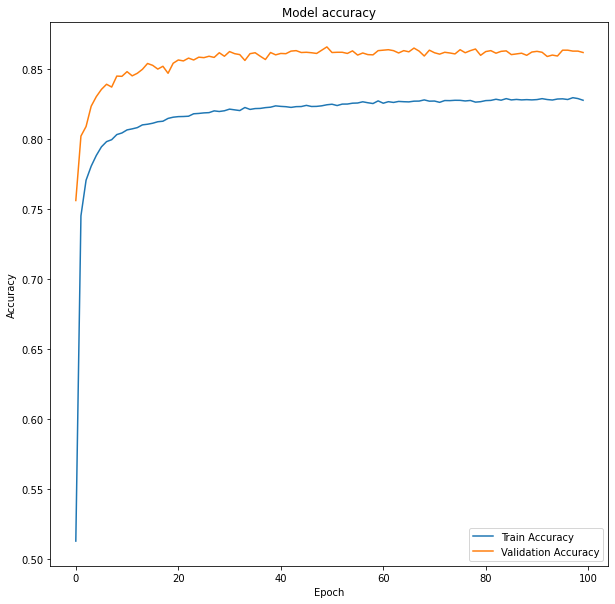

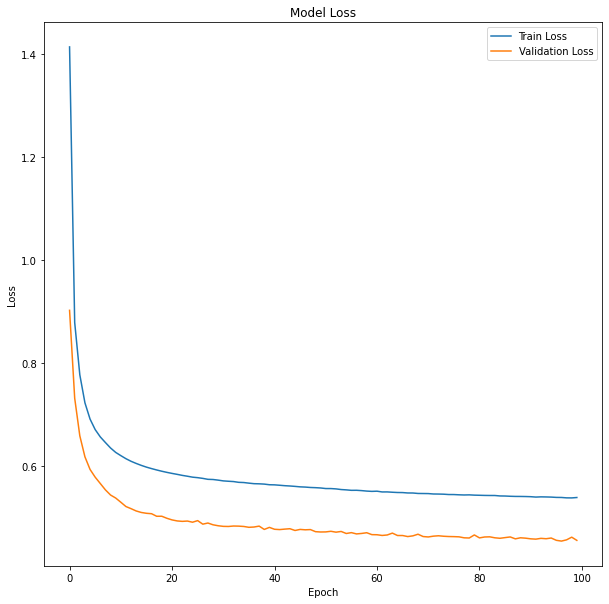

In [ ]:
#Plot Accuracy
fig_Accuracy = plt.figure(figsize=(10, 10))
plt.plot(classification.history['accuracy'])
plt.plot(classification.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy","Validation Accuracy"])
plt.show()
fig_Accuracy.savefig("Accuracy_Model.png")

#Plot Loss
fig_Loss = plt.figure(figsize=(10, 10))
plt.plot(classification.history['loss'])
plt.plot(classification.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss","Validation Loss"])
plt.show()

In [ ]:
test_targets=np_utils.to_categorical(y_te)
encoded_x_te=encoder.predict(x_te, batch_size=batch_size)
cls.evaluate(encoded_x_te,test_targets)

10000/10000 [==============================] - 1s 69us/step


[0.5940444250106811, 0.8163999915122986]

In [ ]:
x = lambda a : a + 10
print(x(5))

def myfunc(n):
  return lambda a : a * n

mydoubler = myfunc(2)

print(mydoubler)


15
<function myfunc.<locals>.<lambda> at 0x7fca1fdb4bf8>


In [ ]:
print(y_tr.shape)

(60000,)
